# Gensim Movie Tutorial

Python の Gensim ライブラリを使ったチュートリアル https://github.com/RaRe-Technologies/movie-plots-by-genre の練習ノートです。

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from smart_open import smart_open
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np


このチュートリアルの目的は、映画の粗筋からジャンル名を当てる事です。まずデータを読み込みます。

In [3]:
tagged_plots_movielens = "https://raw.githubusercontent.com/RaRe-Technologies/movie-plots-by-genre/master/data/tagged_plots_movielens.csv"
df = pd.read_csv(smart_open(tagged_plots_movielens)).dropna()
display(df)
print(f'plot: {df.iloc[12]["plot"]}')
print(f'tag: {df.iloc[12]["tag"]}')

,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
...,...,...,...,...
2443,2443,148618,Three kids who travel back in time to 65 milli...,animation
2444,2444,148624,"Top Cat and the gang face a new police chief, ...",animation
2445,2445,149088,Raggedy Ann and the rest of the toys in Marcel...,animation
2446,2446,149406,"Continuing his ""legendary adventures of awesom...",comedy


plot: In a future world devastated by disease, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human population on the planet.
tag: sci-fi


12 行目の内容を抜き出して見ました。plot が粗筋、tag がジャンル名です。

Comedy / All: 0.32138442521631644


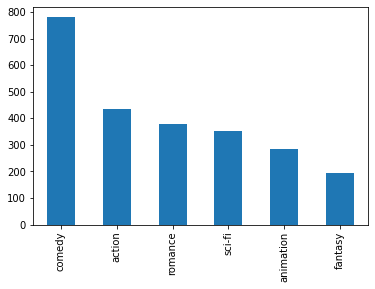

In [4]:
df.tag.value_counts().plot.bar()
print("Comedy / All:", len(df[df.tag=="comedy"]) / len(df))

comedy が突出して多いので、何でもかんでも comedy と予測しただけで 40% の正確性になってしまうらしいです。(32% の間違いではないか?)

教師データとテストデータに分けます。データの一割をテストデータに取っておいて残りが教師データです。ジャンルが偏ってないか一応確認。

Count train: 2184
Count test_data: 243


<AxesSubplot:>

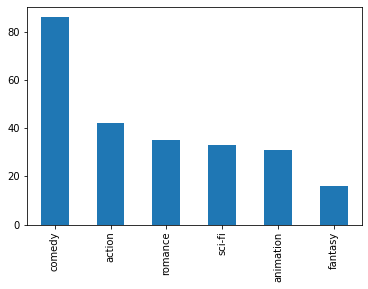

In [5]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
print("Count train:", len(train_data))
print("Count test_data:", len(test_data))
test_data.tag.value_counts().plot.bar()


## Model evaluation approach

これから色々な手法を比較していきます。

In [6]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(my_tags))
    #target_names = my_tags
    
    target_names = df.tag.unique()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

## Bag of words

まず一番簡単な Bag of words を試します。Bag of worlds とは、単語の出現頻度を数えて文の特徴ベクトルとする物です。

ここでは sklearn の CountVectorizer を使います。文章を単語ごとに区切る tokenizer を内蔵している優れものです。

In [7]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word",
    stop_words='english',
    max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['plot'])

CPU times: user 102 ms, sys: 2.28 ms, total: 104 ms
Wall time: 104 ms


試しに教師データの最初の粗筋がどのように変換されたか見てみます。CountVectorizer はレアすぎる単語や頻繁すぎる単語は除外してくれるので、それなりに文章の特徴を表す単語がカウントされています。

In [8]:
def show_count(index):
    print("plot:", train_data.iloc[index]["plot"])
    print("count:")
    print({
        count_vectorizer.get_feature_names()[key]: train_data_features[index, key]
            for key
            in train_data_features[index].indices})
          
show_count(1)

plot: In the early 1960's, sixteen year old Jenny Mellor lives with her parents in the London suburb of Twickenham. On her father's wishes, everything that Jenny does is in the sole pursuit of being accepted into Oxford, as he wants her to have a better life than he. Jenny is bright, pretty, hard working but also naturally gifted. The only problems her father may perceive in her life is her issue with learning Latin, and her dating a boy named Graham, who is nice but socially awkward. Jenny's life changes after she meets David Goldman, a man over twice her age. David goes out of his way to show Jenny and her family that his interest in her is not improper and that he wants solely to expose her to cultural activities which she enjoys. Jenny quickly gets accustomed to the life to which David and his constant companions, Danny and Helen, have shown her, and Jenny and David's relationship does move into becoming a romantic one. However, Jenny slowly learns more about David, and by associat

得られた Bag of words を特徴ベクトルとして、LogisticRegression でジャンルの予測器を作ってみます。

In [9]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=-1, C=1e5)
logreg.fit(train_data_features, train_data['tag'])
logreg

CPU times: user 50.5 ms, sys: 99.3 ms, total: 150 ms
Wall time: 941 ms


LogisticRegression(C=100000.0, n_jobs=-1)

テストデータを使って評価すると、44% とまあまあ良い正答率です。特に amination や comedy の成績が良いです。

accuracy 0.4444444444444444
confusion matrix
 [[23  2 10  0  4  3]
 [ 2 11  8  2  3  5]
 [12  8 45  2 17  2]
 [ 3  2  2  3  5  1]
 [ 3  4 12  1 14  1]
 [ 9  4  6  2  0 12]]
(row=expected, col=predicted)
CPU times: user 85.4 ms, sys: 5.37 ms, total: 90.7 ms
Wall time: 81.7 ms


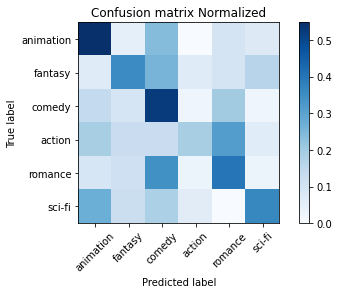

In [10]:
%%time

predict(count_vectorizer, logreg, test_data)

ジャンルを特定するために特徴のある単語を確認します。

In [11]:
my_tags = df.tag.unique()
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]


# words for the fantasy genre
genre_tag_id = 5
print(my_tags[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

sci-fi


['future',
 'futuristic',
 'cube',
 'enterprise',
 'space',
 'suggests',
 'technology',
 'alien',
 'deep',
 'experience']